In [1]:
from pystac_client import Client
from odc.stac import load
import xarray as xr
import numpy as np

import odc.geo # noqa

In [2]:
catalog = "https://stac.staging.digitalearthpacific.org"
collection = "dep_s2_mangroves"

In [11]:
# Coordinates grabbed from Google Maps
# PNG
ll = (-10.800973693423714, 140.80478411776494)
ur = (-1.2136583917602053, 154.35868945055017)

# # Ba river mouth, Fiji
# ll = (-17.500881, 177.608558)
# ur = (-17.420771, 177.702546)

# # Southeast PNG
# ll = (-10.590125, 149.844629)
# ur = (-10.360110, 150.195631)

bbox = (ll[1], ll[0], ur[1], ur[0])

# Find STAC items
client = Client.open(catalog)
items = client.search(collections=[collection], bbox=bbox).items()
items = [i for i in items]

print(f"Found {len(items)} items")

Found 420 items


In [ ]:
config = {
    collection: {
        "assets": {
            "mangroves": {"data_type": "int16"}
        }
    }
}

data = load(items, bbox=bbox, bands=["mangroves"], stac_cfg=config)
data

In [ ]:
data.mangroves.plot.imshow(
    col="time",
    col_wrap=4,
    levels=[0, 1, 2, 3],
    colors=["white", "yellow", "green", "darkgreen"],
)

In [7]:
# Define the values you want to count (0, 1, and 2)
values_to_count = [0, 1, 2]

# Initialize an empty DataArray to store the counts
count_array = xr.DataArray(
    np.zeros((len(data["time"]), len(values_to_count))),
    coords={"time": data["time"], "values": values_to_count},
    dims=["time", "values"],
)

# Loop through each value and count occurrences in each year
for time in data.time:
    year = time.values.astype("datetime64[Y]")
    one_year_data = data.sel(time=time)
    count = one_year_data.mangroves.groupby(one_year_data.mangroves).count()
    for i, v in enumerate(values_to_count):
        if v not in count.mangroves:
            # Add the missing count to the array
            count_array.loc[{"time": time, "values": v}] = 0
        else:
            # Add the count to the array
            val = count.sel(mangroves=v)
            count_array.loc[{"time": time, "values": v}] = val * 10 / 10000

# Rename the count variable
count_array = count_array.rename("count")
count_array

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


<xarray.DataArray 'count' (time: 7, values: 3)>
array([[  11.638,   99.39 ,  939.565],
       [  14.618,  191.442,  844.533],
       [  11.438,   75.796,  963.359],
       [  15.998,  228.366,  806.229],
       [  15.773,  157.09 ,  877.73 ],
       [  16.518,  601.871,  432.204],
       [  14.829,   19.137, 1016.627]])
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01 2017-01-01 ... 2022-01-01
  * values   (values) int64 0 1 2

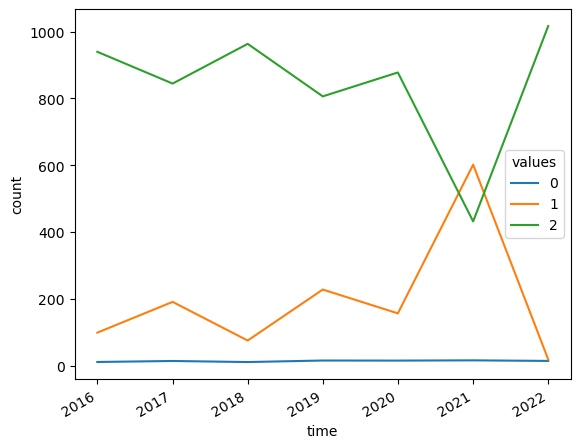

In [8]:
count_array.plot.line(x="time", hue="values")

In [ ]:
# for time in data.time:
#     year = time.values.astype("datetime64[Y]")
#     one_year_data = data.sel(time=time)
#     one_year_data.mangroves.odc.write_cog(f"mangroves_{year}.tif")